<a href="https://colab.research.google.com/github/DanielBugelnig/U-Net/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchinfo

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#pytorch libraries
import torch
import torch.nn.functional as F #for ReLu
import torchvision.transforms.functional as Trans
from torchinfo import summary
from torch import optim, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter, map_coordinates

In [5]:
def init_weights(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        #Apply He for ReLU
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')



class UNet(nn.Module):
    def __init__(self, input_number, output_number):
        super(UNet, self).__init__()
        self.input_number = input_number
        self.output_number = output_number

        #  Initialize weights
        self.apply(init_weights)


        # Encoder
        # input: 4d tensor: batch_size x input_number x 572x572 --> input number=1 for grayscale image, 3 for RGB image
        # assuming 572x572 image
        self.conv1 = nn.Conv2d(self.input_number, 64, kernel_size=3, padding=0) # 64x570x570
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=0) # 64x568x568
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 64x284x284

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=0) # 128x282x282
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=0) # 128x280x280
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 128x140x140

        self.conv5 = nn.Conv2d(128,256, kernel_size=3, padding=0) # 256x138x138
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=0) # 256x136x136
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 256x68x68

        self.conv7 = nn.Conv2d(256, 512, kernel_size=3, padding=0) # 512x66x66
        self.conv8 = nn.Conv2d(512, 512, kernel_size=3, padding=0) # 512x64x64
        self.maxPool4 = nn.MaxPool2d(kernel_size=2, stride=2) # 512x32x32

        self.conv9 = nn.Conv2d(512, 1024, kernel_size=3, padding=0) # 1024x30x30
        self.conv10 = nn.Conv2d(1024, 1024, kernel_size=3, padding=0) # 1024x28x28


        # Between Decoder and Encoder one dropout connection is added
        # Dropout layer
        self.drop = nn.Dropout(p=0.1)

        # Decoder
        # Upsampling by a factor of 2, --> stride=2, kernel_size=2
        # 2x2 up convolution halves the feature channels

        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # 512x56x56 --> output size formular(input) # stride * (input-1) + kernel_size -2 *padding + output_padding = 2*(28-1) + 2 - 2*0 + 0 = 56
        self.conv1b = nn.Conv2d(1024, 512, kernel_size=3, padding=0) # 512x54x54 other 512 features come from encoder site
        self.conv2b = nn.Conv2d(512, 512, kernel_size=3, padding=0) # 512x52x52

        self.upconv2 = nn.ConvTranspose2d(512, 256, 2, 2) # 512x104x104
        self.conv3b = nn.Conv2d(512, 256, 3, padding=0) #256x102x102
        self.conv4b = nn.Conv2d(256, 256, 3, padding=0) # 256x100x100

        self.upconv3 = nn.ConvTranspose2d(256, 128, 2,2,) #256x200x200
        self.conv5b = nn.Conv2d(256, 128, 3, padding=0) #128x198x198
        self.conv6b = nn.Conv2d(128, 128, 3, padding=0) #128x196x196

        self.upconv4 = nn.ConvTranspose2d(128, 64, 2, 2) #128x392x392
        self.conv7b = nn.Conv2d(128, 64, 3, padding=0) #64x390x390
        self.conv8b = nn.Conv2d(64,64,3, padding=0) # 64x388x388
        self.final_conv = nn.Conv2d(64, self.output_number, kernel_size=1, padding=0) #2x388x388

    def cropConcat(self, encoder, decoder):
        # crops the encoder tensor and concatenate its with the decoder tensor
        _,_,H,W = decoder.shape
        cropped_enc = Trans.center_crop(encoder, [H,W]) # crops the encoder tensor in the centre
        return torch.cat((cropped_enc, decoder), dim=1) # concatenates at the feature dimension

    def forward(self, x):
        # Encoder
        x = F.relu(self.conv1(x))
        x1 = F.relu(self.conv2(x))
        x = self.maxPool1(x1)

        x = F.relu(self.conv3(x))
        x2 = F.relu(self.conv4(x))
        x = self.maxPool2(x2)

        x = F.relu(self.conv5(x))
        x3 = F.relu(self.conv6(x))
        x = self.maxPool3(x3)

        x = F.relu(self.conv7(x))
        x4 = F.relu(self.conv8(x))
        x = self.maxPool4(x4)

        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))

        # Dropout
        x = self.drop(x)

        # Decoder
        x = self.upconv1(x)  # size 512x56x56

        x = self.cropConcat(x4, x) # concatination1 size 1024x56x56
        x = F.relu(self.conv1b(x))
        x = F.relu(self.conv2b(x))
        x = self.upconv2(x)

        x = self.cropConcat(x3,x)
        x = F.relu(self.conv3b(x))
        x = F.relu(self.conv4b(x))
        x = self.upconv3(x)

        x = self.cropConcat(x2,x)
        x = F.relu(self.conv5b(x))
        x = F.relu(self.conv6b(x))
        x = self.upconv4(x)

        x = self.cropConcat(x1,x)
        x = F.relu(self.conv7b(x))
        x = F.relu(self.conv8b(x))
        x = self.final_conv(x)
        #x = F.softmax(x, dim=1)
        return x


In [6]:
model = UNet(1,1)
summary(model, input_size=(1, 1, 572, 572))  # Example input size

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 388, 388]          --
├─Conv2d: 1-1                            [1, 64, 570, 570]         640
├─Conv2d: 1-2                            [1, 64, 568, 568]         36,928
├─MaxPool2d: 1-3                         [1, 64, 284, 284]         --
├─Conv2d: 1-4                            [1, 128, 282, 282]        73,856
├─Conv2d: 1-5                            [1, 128, 280, 280]        147,584
├─MaxPool2d: 1-6                         [1, 128, 140, 140]        --
├─Conv2d: 1-7                            [1, 256, 138, 138]        295,168
├─Conv2d: 1-8                            [1, 256, 136, 136]        590,080
├─MaxPool2d: 1-9                         [1, 256, 68, 68]          --
├─Conv2d: 1-10                           [1, 512, 66, 66]          1,180,160
├─Conv2d: 1-11                           [1, 512, 64, 64]          2,359,808
├─MaxPool2d: 1-12                        [1, 51

In [17]:
# Dataset class
class Dataset(Dataset):
    def __init__(self, image_path, label_path, image_transform=None, label_transform=None, elastic_transform=None):
        self.images = Image.open(image_path)
        self.labels = Image.open(label_path)
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.elastic_transform = elastic_transform

    def __len__(self):
        return self.images.n_frames


    def __getitem__(self, idx):
        # Access specific frame
        self.images.seek(idx)
        self.labels.seek(idx)



        # Convert to grayscale
        image = self.images.convert("L")
        label = self.labels.convert("L")

        # Apply elastic transformation
        if self.elastic_transform:
            image, label = self.elastic_transform(image, label)

         # Random horizontal flipping
        if random.random() > 0.5:
            image = Trans.hflip(image)
            label = Trans.hflip(label)

      # Random vertical flipping
        if random.random() > 0.5:
            image = Trans.vflip(image)
            label = Trans.vflip(label)

        # Transform to tensor
        image = Trans.to_tensor(image)
        label = Trans.to_tensor(label)

        return image, label

In [18]:
class ElasticTransform:
    def __init__(self, alpha=34, sigma=4):
        #Elastic transform for image and label
        self.alpha = alpha
        self.sigma = sigma

    def __call__(self, image, mask):
        # Convert PIL images to numpy arrays
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Generate random displacement fields
        random_state = np.random.RandomState(None)
        dx = gaussian_filter((random_state.rand(*image_np.shape) * 2 - 1), self.sigma) * self.alpha
        dy = gaussian_filter((random_state.rand(*image_np.shape) * 2 - 1), self.sigma) * self.alpha

        # Create mesh grid for indexing
        shape = image_np.shape
        x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))

        # Apply displacements to the coordinates
        indices = (y + dy).reshape(-1, 1), (x + dx).reshape(-1, 1)

        # Apply the elastic transformation
        distorted_image = map_coordinates(image_np, indices, order=1, mode='reflect').reshape(shape)
        distorted_mask = map_coordinates(mask_np, indices, order=1, mode='reflect').reshape(shape)

        # Convert back to PIL images
        return Image.fromarray(distorted_image), Image.fromarray(distorted_mask)

In [19]:
mean = 0.5
std = 0.2

# Data transforms
basic_transform = transforms.Compose([
    transforms.ToTensor()
])

basic_transform_resize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([572, 572])
])

# do not work, the transform are applied directly in the dataset class
advanced_transform_image = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=15),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[mean], std=[std])
])

advanced_transform_label = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

In [20]:
def computeMeanStd(dataloader):
    mean = 0.0
    std = 0.0
    n_samples = 0

    for images, _ in dataloader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, -1)
        mean += images.mean(1).sum(0)
        std += images.std(1).sum(0)
        n_samples += batch_samples

    mean /= n_samples
    std /= n_samples

    return mean.item(), std.item()

In [21]:
 # for google colab, vanilla dataset ISBI 2012
train_image_path = "/content/drive/My Drive/Machine_Learning/ISBI-2012-challenge/train-volume.tif"
train_label_path = "/content/drive/My Drive/Machine_Learning/ISBI-2012-challenge/train-labels.tif"
test_image_path = "/content/drive/My Drive/Machine_Learning/ISBI-2012-challenge/test-volume.tif"
test_label_path = "/content/drive/My Drive/Machine_Learning/ISBI-2012-challenge/test-labels.tif"

# for google colab, mirrored dataset ISBI 2012
train_image_path = "/content/drive/MyDrive/Machine_Learning/ISBI-2012-mirrored/train-mirror.tif"
train_label_path = "/content/drive/My Drive/Machine_Learning/ISBI-2012-mirrored/train-labels.tif"
test_image_path = "/content/drive/My Drive/Machine_Learning/ISBI-2012-mirrored/test-mirror.tif"
test_label_path = "/content/drive/My Drive/Machine_Learning/ISBI-2012-mirrored/test-labels.tif"


In [27]:
def train(model, dataloader, criterion, optimizer, nrOfEpochs):
  model.train()
  for epoch in range(nrOfEpochs):
      running_loss = 0.0
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          visualize_sample(images[0], labels[0])
          optimizer.zero_grad()
          outputs = model(images)
          labels = Trans.center_crop(labels, [388, 388])
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

      train_loss = running_loss / len(dataloader)
      print(f"Epoch {epoch + 1}/{nrOfEpochs}, Loss: {train_loss:.4f}")


In [23]:
def test(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0

    total_TP = total_TN = total_FP = total_FN = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            outputs_bin = (outputs > 0.5).int()
            labels = Trans.center_crop(labels, [388, 388])
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            total_TP += ((outputs_bin == 1) & (labels == 1)).sum().item()
            total_TN += ((outputs_bin == 0) & (labels == 0)).sum().item()
            total_FP += ((outputs_bin == 1) & (labels == 0)).sum().item()
            total_FN += ((outputs_bin == 0) & (labels == 1)).sum().item()

    test_loss = running_loss / len(dataloader)
    accuracy = (total_TP + total_TN) / (total_TP + total_TN + total_FP + total_FN)
    precision = total_TP / (total_TP + total_FP)
    recall = total_TP / (total_TP + total_FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    print(f"Test loss: {test_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [24]:
 # Initial transform for computing mean and std
computing_mean_std_dataset = Dataset(train_image_path, train_label_path, image_transform=basic_transform, label_transform=basic_transform)
computing_mean_std_dataset_loader = DataLoader(computing_mean_std_dataset, batch_size=1, shuffle=True)


mean, std = computeMeanStd(computing_mean_std_dataset_loader)

print(f"Mean: {mean}, Std: {std}")


# Datasets and loaders
# Vanilla Dataset: use basic_transform_resize
# Mirrored Dataset: use advanced_transform_image and advanced_transform_label or : basic_transform for both
elastic_transform = ElasticTransform(alpha=34, sigma=4)
train_dataset = Dataset(train_image_path, train_label_path, elastic_transform=elastic_transform)
test_dataset = Dataset(test_image_path, test_label_path, image_transform=advanced_transform_image, label_transform=advanced_transform_label, elastic_transform=elastic_transform)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

Mean: 0.4946057200431824, Std: 0.16874872148036957


In [25]:
def visualize_sample(image, label):
    # Convert tensors to numpy arrays for visualization
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
        image = np.squeeze(image)  # Remove channel dimension if grayscale
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
        label = np.squeeze(label)  # Remove channel dimension if necessary

    # Plot the image and label side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Display image
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Transformed Image')
    ax[0].axis('off')

    # Display label
    ax[1].imshow(label, cmap='gray')
    ax[1].set_title('Transformed Label')
    ax[1].axis('off')

    plt.show()

Starting training


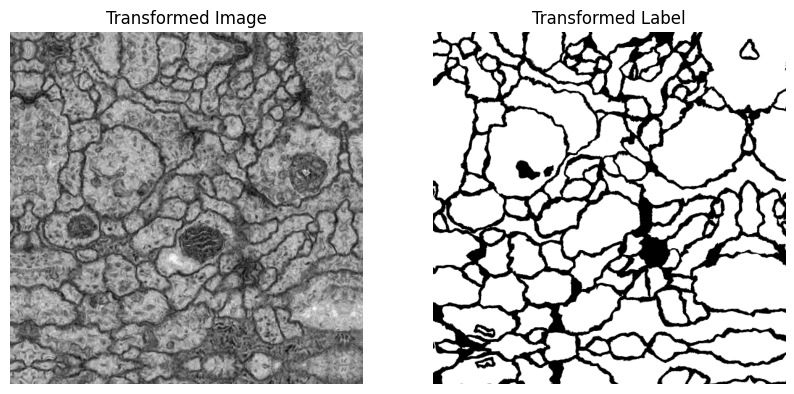

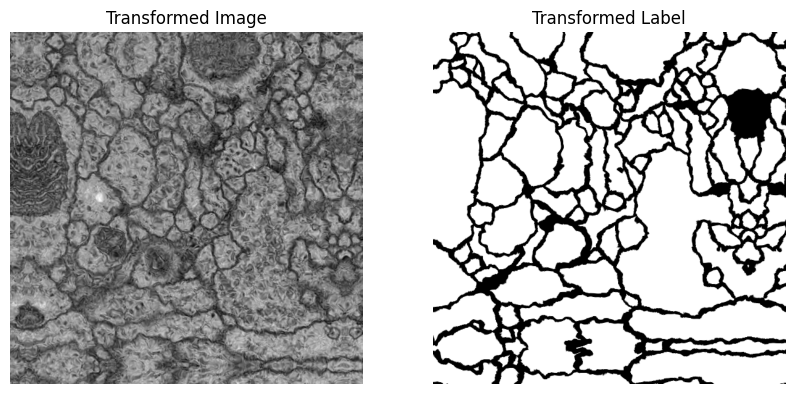

KeyboardInterrupt: 

In [28]:
# Clearing CUDA memory
torch.cuda.empty_cache()
# Training

print("Starting training")
train(model, train_loader, criterion, optimizer, nrOfEpochs=20)

In [ ]:
# Testing
print("Starting evaluation")
test(model, test_loader, criterion)

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/Machine_Learning/results/model_50ep_dropout10_mirror_transf_normalized.pth")
print("Model saved")